# Healthcare analytics

### Roger Montané Güell (1569031)

Kaggle dataset: https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii

In [2]:
import numpy as np

import collections

from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd

import scipy.stats

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import lightgbm as lgb

import pycaret.classification as pyc

Let's load the data:

In [3]:
# Function to read csv files and save them as a pandas structure
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

In [4]:
train = load_dataset('../data/train_data.csv')
train_data = train.copy(deep=True)
train_data.shape

(318438, 18)

In [5]:
test = load_dataset('../data/test_data.csv')
test_data = test.copy(deep=True)
test_data.shape

(137057, 17)

---

### Exploratory Data Analysis (on the train dataset)
Train data info:

In [6]:
# TODO: carregar i arreglar el dataset de test

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
case_id                              318438 non-null int64
Hospital_code                        318438 non-null int64
Hospital_type_code                   318438 non-null object
City_Code_Hospital                   318438 non-null int64
Hospital_region_code                 318438 non-null object
Available Extra Rooms in Hospital    318438 non-null int64
Department                           318438 non-null object
Ward_Type                            318438 non-null object
Ward_Facility_Code                   318438 non-null object
Bed Grade                            318325 non-null float64
patientid                            318438 non-null int64
City_Code_Patient                    313906 non-null float64
Type of Admission                    318438 non-null object
Severity of Illness                  318438 non-null object
Visitors with Patient                318438 non-null

Let's see the columns of the dataset:

In [8]:
train_data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


We also check for NaN values:

In [9]:
train_data.isna().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

We can either fill this Nan values with a statistical method (mean, mode, etc.), or just get rid of every row that has a Nan value:

In [10]:
#TODO: fill NaN values

# For now let's just drop them
train_data = train_data.dropna()
train_data.isna().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

In [11]:
test_data = test_data.dropna()
test_data.isna().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
dtype: int64

In [12]:
train_data.shape

(313793, 18)

In [13]:
test_data.shape

(134865, 17)

---

#### Feature selection
We have to consider the following:
* `case_id`, `patientid`, `Hospital_code` are not relevant, they are just id's
* `City_hospital_code` is also not used since we can use `Hospital_region_code` instead
* `City_code_patient` does not seem relevant, the city a patient is from should not affect the LOS
* `Hospital_type_code`, `Hospital_region_code`, `Department`, `Ward_Type` and `Ward_Facility_Code` will be One hot encoded

In [14]:
train_data.drop(['case_id', 'patientid', 'Hospital_code', 'City_Code_Hospital', 'City_Code_Patient']
               , axis = 1, inplace = True)
test_data.drop(['case_id', 'patientid', 'Hospital_code', 'City_Code_Hospital', 'City_Code_Patient']
               , axis = 1, inplace = True)
train_data.head()

,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,c,Z,3,radiotherapy,R,F,2.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,c,Z,2,radiotherapy,S,F,2.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,e,X,2,anesthesia,S,E,2.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,b,Y,2,radiotherapy,R,D,2.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,b,Y,2,radiotherapy,S,D,2.0,Trauma,Extreme,2,51-60,5558.0,41-50


---

#### Numerical and categorical data

In [15]:
cat_cols=[]
num_cols=[]

for col in train_data.columns:
    if train_data[col].dtypes == 'object':
        cat_cols.append(col)
        
for col in train_data.columns:
    if train_data[col].dtypes != 'object':
        num_cols.append(col)
        
print("Categorical columns:")
print(cat_cols)

Categorical columns:
['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']


In [16]:
print("Numerical columns:")
print(num_cols)

Numerical columns:
['Available Extra Rooms in Hospital', 'Bed Grade', 'Visitors with Patient', 'Admission_Deposit']


---

#### Analyising numerical variables

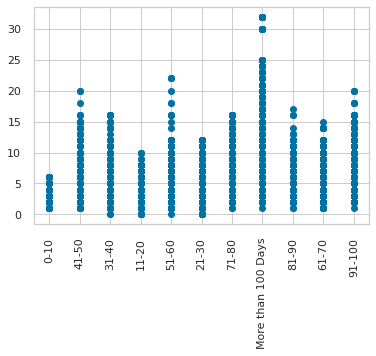

In [17]:
plt.xticks(rotation=90)
plt.scatter(train['Stay'], train['Visitors with Patient'])

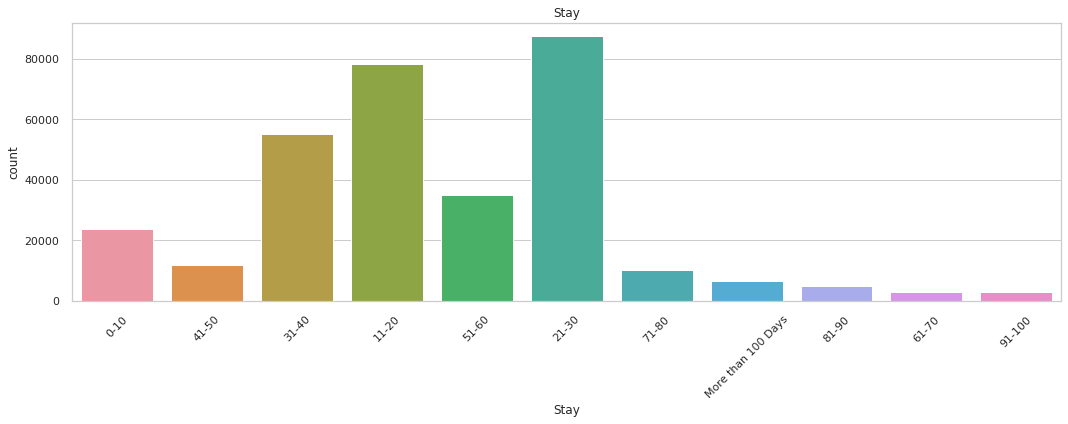

In [18]:
figure(figsize=(15,5))
sns.countplot('Stay',data=train)
plt.title('Stay')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

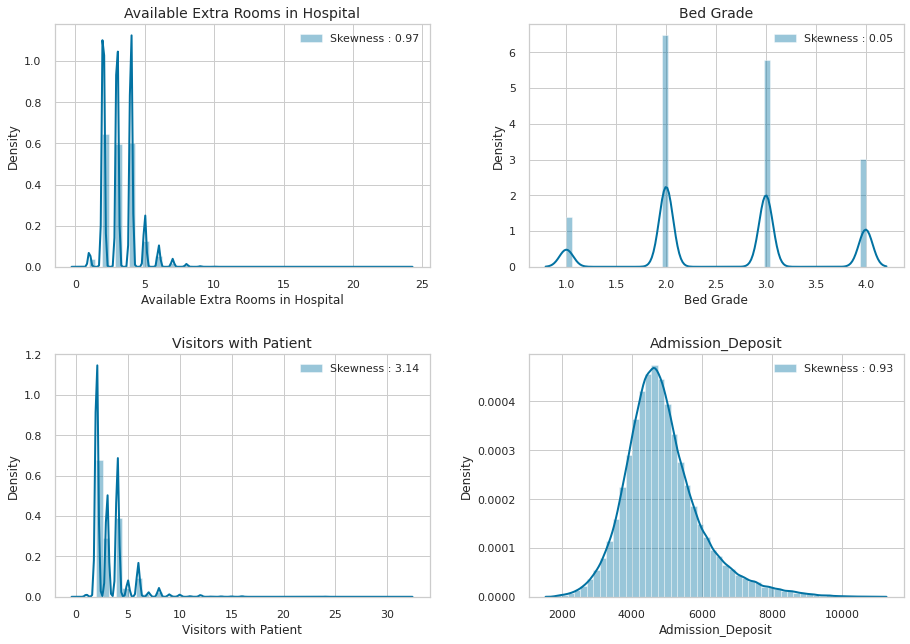

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))
fig.tight_layout(pad=5.0)

for ax, category in zip(ax.flatten(), num_cols):
    sns.distplot(ax=ax, a=train[category].dropna(), label="Skewness : %.2f"%(train[category].skew()))
    ax.set_title(category, fontsize = 14)
    ax.legend(loc = 'best')

In [20]:
# TODO: explicar skewness

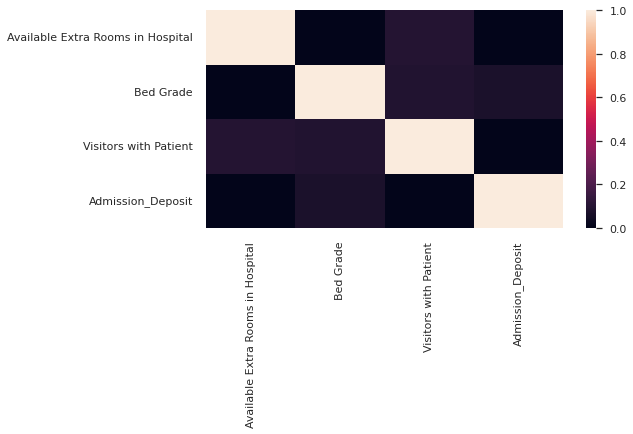

In [21]:
heatmapdata = train[num_cols]
cormat = heatmapdata.corr()
fig, ax = plt.subplots(figsize = (8,4))
sns.heatmap(data = cormat, vmin=0, vmax=1)
plt.show()

In [22]:
# TODO: explicar correlacions, mes analisis?

#### Analysing categorical variables

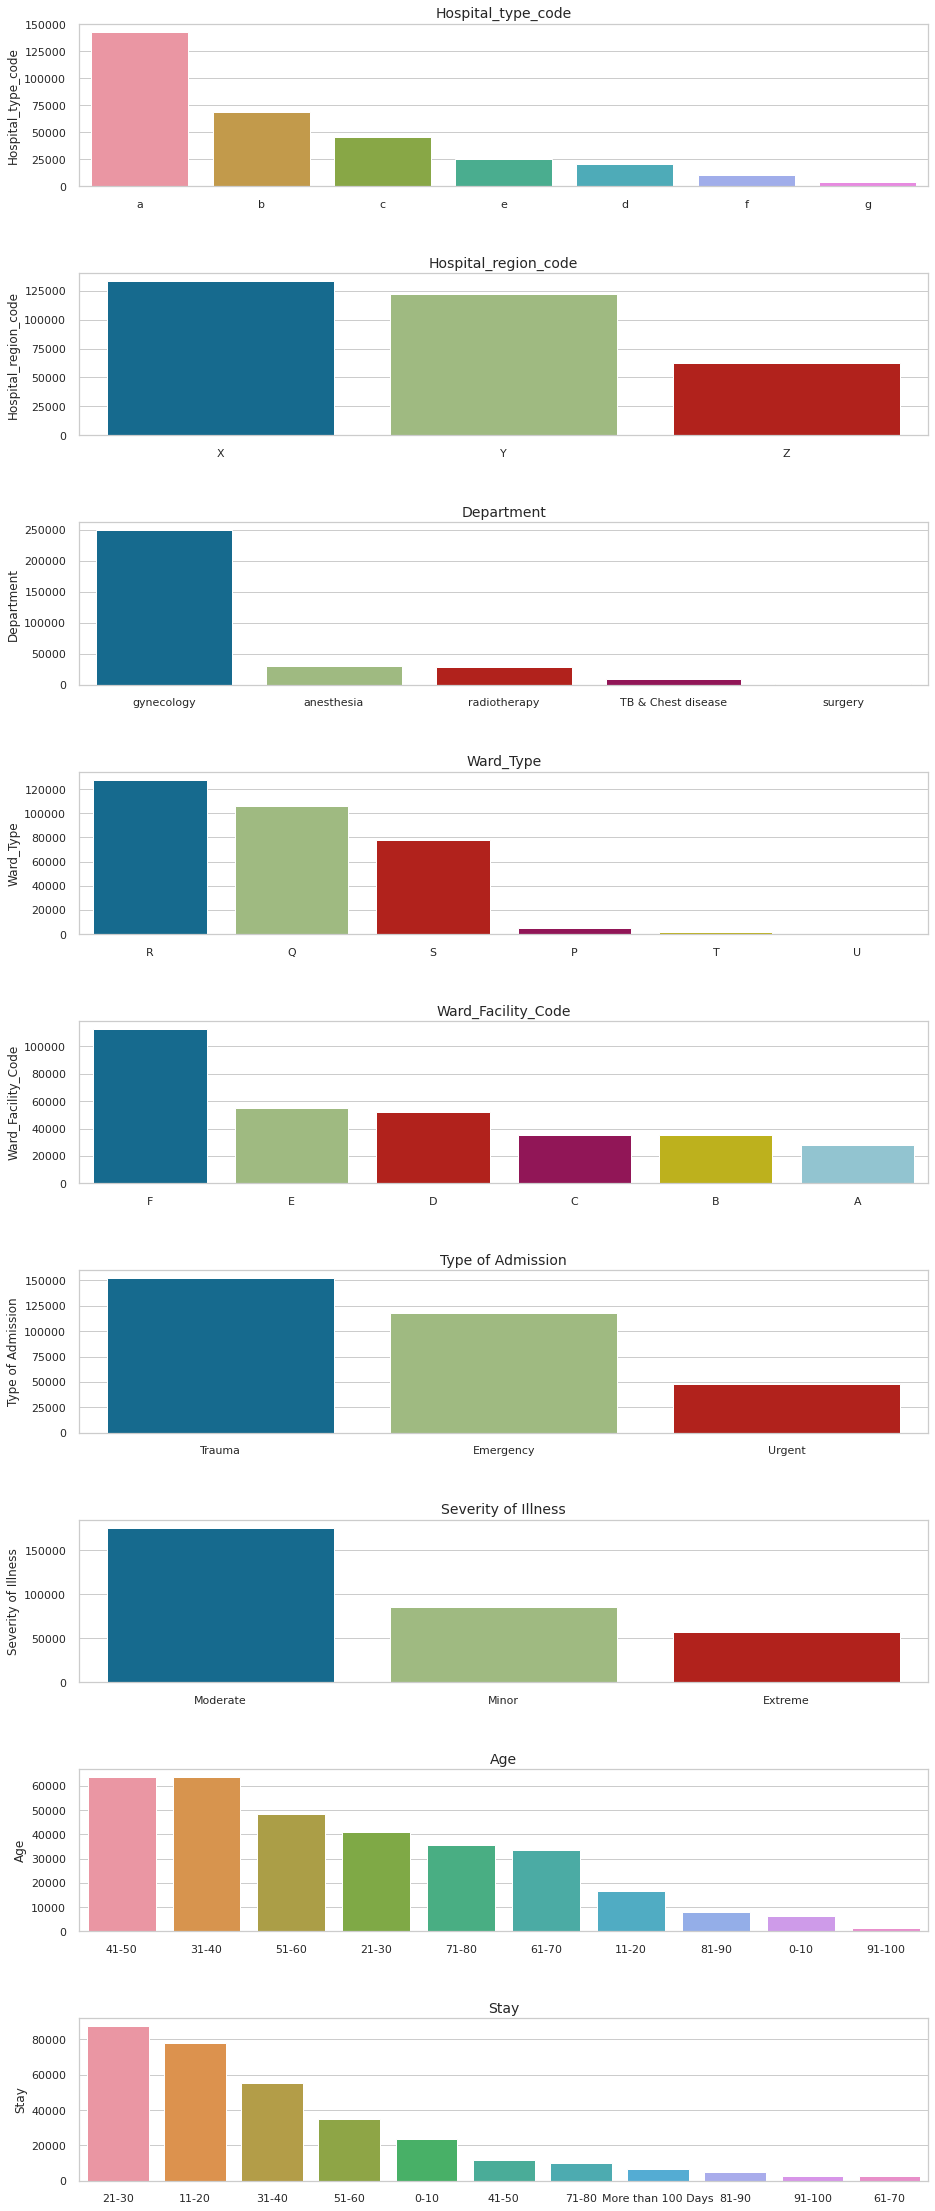

In [23]:
fig, ax = plt.subplots(len(cat_cols),1, figsize = (14, 32))
fig.tight_layout(pad = 5.0)

for ax, category in zip(ax.flatten(), cat_cols):
    x_axis = train[category].fillna('NaN').value_counts().index
    y_axis = train[category].fillna('NaN').value_counts()
    sns.barplot(ax = ax, x = x_axis, y = y_axis, order =  x_axis)
    ax.set_title(category, fontsize = 14)
    
plt.show()

In [24]:
# TODO: altres visualitzacions, com les que feiem a la practica 1 de scatter i linia etc

---

### Data preprocessing

#### Encoding categorical data

In [25]:
for col in cat_cols:
    print(col, sorted(train_data[col].unique()), len(sorted(train_data[col].unique())), "\n")

Hospital_type_code ['a', 'b', 'c', 'd', 'e', 'f', 'g'] 7 

Hospital_region_code ['X', 'Y', 'Z'] 3 

Department ['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy', 'surgery'] 5 

Ward_Type ['P', 'Q', 'R', 'S', 'T', 'U'] 6 

Ward_Facility_Code ['A', 'B', 'C', 'D', 'E', 'F'] 6 

Type of Admission ['Emergency', 'Trauma', 'Urgent'] 3 

Severity of Illness ['Extreme', 'Minor', 'Moderate'] 3 

Age ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'] 10 

Stay ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', 'More than 100 Days'] 11 



`Type of admission`, `severity of illness`, `age` and `stay` can be label encoded since there is an ordinality. All the others must be one hot encoded.

* **Label Encoding ordinal catgorical data**

In [26]:
enc_tra_data = train_data.copy(deep=True)
enc_tes_data = test_data.copy(deep=True)

print(enc_tra_data.shape)

(313793, 13)


In [27]:
def labelEncode(enc_data, data, test=False):
    label_encoder = preprocessing.LabelEncoder()

    enc_data['Type of Admission'] = label_encoder.fit_transform(data['Type of Admission'])
    enc_data['Severity of Illness'] = label_encoder.fit_transform(data['Severity of Illness'])
    enc_data['Age'] = label_encoder.fit_transform(data['Age'])
    if not test:
        enc_data['Stay'] = label_encoder.fit_transform(data['Stay'])
    
    return enc_data

In [28]:
# LabelEncoding
"""label_encoder = preprocessing.LabelEncoder()

enc_tra_data['Type of Admission'] = label_encoder.fit_transform(train_data['Type of Admission'])
enc_tra_data['Severity of Illness'] = label_encoder.fit_transform(train_data['Severity of Illness'])
enc_tra_data['Age'] = label_encoder.fit_transform(train_data['Age'])
enc_tra_data['Stay'] = label_encoder.fit_transform(train_data['Stay'])"""

enc_tra_data = labelEncode(enc_tra_data, train_data)
enc_tes_data = labelEncode(enc_tes_data, test_data, test=True)

print(enc_tra_data.shape)

enc_tra_data.head()

(313793, 13)


,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,c,Z,3,radiotherapy,R,F,2.0,0,0,2,5,4911.0,0
1,c,Z,2,radiotherapy,S,F,2.0,1,0,2,5,5954.0,4
2,e,X,2,anesthesia,S,E,2.0,1,0,2,5,4745.0,3
3,b,Y,2,radiotherapy,R,D,2.0,1,0,2,5,7272.0,4
4,b,Y,2,radiotherapy,S,D,2.0,1,0,2,5,5558.0,4


* **One hot Encoding nominal categorical data**

In [29]:
def oneHotEncode(enc_data, data, cat_cols):
    for label in cat_cols[:5]:
        one_hot_encoder = preprocessing.OneHotEncoder(sparse=False, drop = 'first', categories = 'auto')
        one_hot_encoder.fit(data[cat_cols[:5]])
        one_hot_df = one_hot_encoder.transform(data[cat_cols[:5]])
    
        for i in range(one_hot_df.shape[1]):
            enc_data[label + '_' + str(i)] = one_hot_df[:,i]
            
    # Drop unnecessary columns
    enc_data.drop(['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code']
           , axis = 1, inplace = True)
            
    return enc_data

In [30]:
# OneHotEncoding
"""for label in cat_cols[:5]:
    one_hot_encoder = preprocessing.OneHotEncoder(sparse=False, drop = 'first', categories = 'auto')
    one_hot_encoder.fit(train_data[cat_cols[:5]])
    one_hot_df = one_hot_encoder.transform(train_data[cat_cols[:5]])
    
    for i in range(one_hot_df.shape[1]):
        encoded_data[label + '_' + str(i)] = one_hot_df[:,i]"""
enc_tra_data = oneHotEncode(enc_tra_data, train_data, cat_cols)
enc_tes_data = oneHotEncode(enc_tes_data, test_data, cat_cols)

print(enc_tra_data.shape)

enc_tra_data.head()

(313793, 118)


,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Hospital_type_code_0,Hospital_type_code_1,Hospital_type_code_2,Hospital_type_code_3,Hospital_type_code_4,Hospital_type_code_5,Hospital_type_code_6,Hospital_type_code_7,Hospital_type_code_8,Hospital_type_code_9,Hospital_type_code_10,Hospital_type_code_11,Hospital_type_code_12,Hospital_type_code_13,Hospital_type_code_14,Hospital_type_code_15,Hospital_type_code_16,Hospital_type_code_17,Hospital_type_code_18,Hospital_type_code_19,Hospital_type_code_20,Hospital_type_code_21,Hospital_region_code_0,Hospital_region_code_1,Hospital_region_code_2,Hospital_region_code_3,Hospital_region_code_4,Hospital_region_code_5,Hospital_region_code_6,Hospital_region_code_7,Hospital_region_code_8,Hospital_region_code_9,Hospital_region_code_10,Hospital_region_code_11,Hospital_region_code_12,Hospital_region_code_13,Hospital_region_code_14,Hospital_region_code_15,Hospital_region_code_16,Hospital_region_code_17,Hospital_region_code_18,Hospital_region_code_19,Hospital_region_code_20,Hospital_region_code_21,Department_0,Department_1,Department_2,Department_3,Department_4,Department_5,Department_6,Department_7,Department_8,Department_9,Department_10,Department_11,Department_12,Department_13,Department_14,Department_15,Department_16,Department_17,Department_18,Department_19,Department_20,Department_21,Ward_Type_0,Ward_Type_1,Ward_Type_2,Ward_Type_3,Ward_Type_4,Ward_Type_5,Ward_Type_6,Ward_Type_7,Ward_Type_8,Ward_Type_9,Ward_Type_10,Ward_Type_11,Ward_Type_12,Ward_Type_13,Ward_Type_14,Ward_Type_15,Ward_Type_16,Ward_Type_17,Ward_Type_18,Ward_Type_19,Ward_Type_20,Ward_Type_21,Ward_Facility_Code_0,Ward_Facility_Code_1,Ward_Facility_Code_2,Ward_Facility_Code_3,Ward_Facility_Code_4,Ward_Facility_Code_5,Ward_Facility_Code_6,Ward_Facility_Code_7,Ward_Facility_Code_8,Ward_Facility_Code_9,Ward_Facility_Code_10,Ward_Facility_Code_11,Ward_Facility_Code_12,Ward_Facility_Code_13,Ward_Facility_Code_14,Ward_Facility_Code_15,Ward_Facility_Code_16,Ward_Facility_Code_17,Ward_Facility_Code_18,Ward_Facility_Code_19,Ward_Facility_Code_20,Ward_Facility_Code_21
0,3,2.0,0,0,2,5,4911.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2.0,1,0,2,5,5954.0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,2.0,1,0,2,5,4745.0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2,2.0,1,0,2,5,7272.0,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,

In [31]:
"""for label in cat_cols[:5]:
    X = one_hot_encoder.fit_transform(train_data[label].values.reshape(-1,1))
    one_hot_df = pd.DataFrame(X, columns=[label+"_"+str(i) for i in sorted(train_data[label].unique())])
    encoded_data = pd.concat([encoded_data, one_hot_df], axis=1)
    encoded_data.drop(label, inplace=True, axis=1)"""

'for label in cat_cols[:5]:\n    X = one_hot_encoder.fit_transform(train_data[label].values.reshape(-1,1))\n    one_hot_df = pd.DataFrame(X, columns=[label+"_"+str(i) for i in sorted(train_data[label].unique())])\n    encoded_data = pd.concat([encoded_data, one_hot_df], axis=1)\n    encoded_data.drop(label, inplace=True, axis=1)'

In [32]:
enc_tra_data.shape

(313793, 118)

#### Standarizing numerical data

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
def standarize(data, st_num_cols):
    sc = StandardScaler()

    sc.fit(data[st_num_cols])
    data[st_num_cols] = sc.transform(data[st_num_cols])
    
    return data

In [35]:
# not all need to be, only avalible_extra_rooms, bed_grade, visitors_with_patient, admission_deposit
st_num_cols = ['Available Extra Rooms in Hospital', 'Bed Grade', 'Visitors with Patient', 'Admission_Deposit']

In [36]:
enc_tra_data = standarize(enc_tra_data, st_num_cols)
enc_tes_data = standarize(enc_tes_data, st_num_cols)

In [37]:
enc_tra_data.shape

(313793, 118)

In [38]:
enc_tra_data[st_num_cols]

,Available Extra Rooms in Hospital,Bed Grade,Visitors with Patient,Admission_Deposit
0,-0.168178,-0.713890,-0.727035,0.026796
1,-1.024400,-0.713890,-0.727035,0.986987
2,-1.024400,-0.713890,-0.727035,-0.126025
3,-1.024400,-0.713890,-0.727035,2.200344
4,-1.024400,-0.713890,-0.727035,0.622427
...,...,...,...,...
318433,-0.168178,1.578068,-0.159419,-0.679308
318434,-1.024400,1.578068,0.408197,1.672838
318435,-0.168178,1.578068,-0.159419,-0.595533
318436,-0.168178,0.432089,0.975813,-1.031900


<AxesSubplot:xlabel='Admission_Deposit', ylabel='Density'>

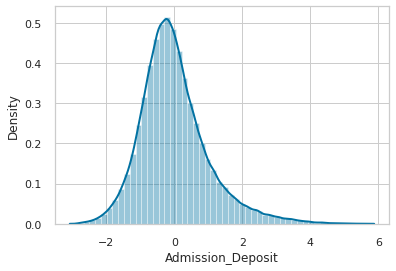

In [39]:
sns.distplot(enc_tra_data['Admission_Deposit'])

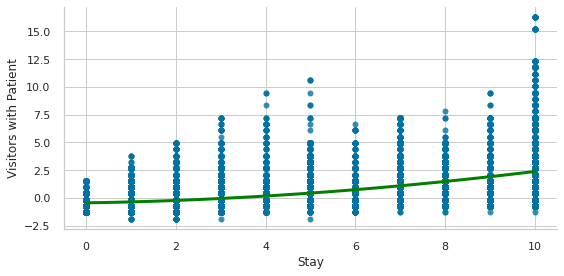

In [40]:
sns.lmplot('Stay', 'Visitors with Patient', enc_tra_data, order = 3, size = 4, aspect = 2, line_kws={'color': 'green'})
plt.show()

* **Applying select best k**

In [41]:
X = enc_tra_data.loc[:, enc_tra_data.columns != 'Stay']
y = enc_tra_data['Stay']

print(X.shape, y.shape)

X_test = enc_tes_data
y_test = np.zeros(X_test.shape[0])

(313793, 117) (313793,)


In [42]:
# Or we could create a function to get X,y (preprocessed thorugh the process above) from a given dataset
def get_X_y(data, cat_cols, num_cols, st_num_cols):
    data = data.dropna()
    data.drop(['case_id', 'patientid', 'Hospital_code', 'City_Code_Hospital', 'City_Code_Patient']
               , axis = 1, inplace = True)
    enc_data = data.copy(deep=True)
    enc_data = labelEncode(enc_data, data)
    enc_data = oneHotEncode(enc_data, data, cat_cols)
    enc_data = standarize(enc_data, st_num_cols)
    
    return enc_data.loc[:, enc_data.columns != 'Stay'], enc_data['Stay']

In [43]:
X, y = get_X_y(train, cat_cols, num_cols, st_num_cols)
print(X.shape, y.shape)

(313793, 117) (313793,)


We have a lot of categories, we can use sklearn's feature selection library to select the $K$ best number of features:

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif

In [45]:
def select_K_best(X_data, y_data, k):
    # Create and fit selector
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_data, y_data)
    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    data_aux = X_data.iloc[:,cols]
    
    return data_aux

In [46]:
X_best_k = select_K_best(X, y, 20)
X_test_best_k = select_K_best(X_test, y_test, 20)

In [47]:
X_best_k

,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Visitors with Patient,Admission_Deposit,Hospital_type_code_12,Hospital_type_code_14,Hospital_type_code_18,Hospital_region_code_12,Hospital_region_code_14,Hospital_region_code_18,Department_12,Department_14,Department_18,Ward_Type_12,Ward_Type_14,Ward_Type_18,Ward_Facility_Code_12,Ward_Facility_Code_14,Ward_Facility_Code_18
0,-0.168178,-0.713890,0,-0.727035,0.026796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.024400,-0.713890,1,-0.727035,0.986987,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.024400,-0.713890,1,-0.727035,-0.126025,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.024400,-0.713890,1,-0.727035,2.200344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.024400,-0.713890,1,-0.727035,0.622427,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,-0.168178,1.578068,0,-0.159419,-0.679308,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
318434,-1.024400,1.578068,2,0.408197,1.672838,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
318435,-0.168178,1.578068,0,-0.159419,-0.595533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318436,-0.168178,0.432089,1,0.975813,-1.031900,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


---

## Models

#### Linear regression

We don't want to use all 118 attributes of the dataset. We will simply select the best $K$ variables to use for each regressor. However, if we tried with all possible values of $K$ (i.e. from 1 to 118), it would be too much time consuming, so we will just set $K = 20$.

In [48]:
# Best 20 features
X_best_k.columns

Index(['Available Extra Rooms in Hospital', 'Bed Grade', 'Type of Admission',
       'Visitors with Patient', 'Admission_Deposit', 'Hospital_type_code_12',
       'Hospital_type_code_14', 'Hospital_type_code_18',
       'Hospital_region_code_12', 'Hospital_region_code_14',
       'Hospital_region_code_18', 'Department_12', 'Department_14',
       'Department_18', 'Ward_Type_12', 'Ward_Type_14', 'Ward_Type_18',
       'Ward_Facility_Code_12', 'Ward_Facility_Code_14',
       'Ward_Facility_Code_18'],
      dtype='object')

* **Linear regressor:**

In [49]:
X_best_k.shape

(313793, 20)

In [50]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X_best_k, y)

regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train) 
print ('\nCoefs (per dim) ', regressor.coef_, ' and intercept: ', regressor.intercept_)
# Best possible score is 1.0, lower values (even negatives!!) are worse.
print ('\nTraining Score:', regressor.score(X_train, y_train) )
print ('Testing Score:', regressor.score(X_val, y_val) )
print ('\nTraining MSE: ', mse(regressor.predict(X_train), y_train))
print ('Testing MSE: ', mse(regressor.predict(X_val), y_val))


Coefs (per dim)  [-2.38162955e-01 -1.22681690e-01  2.07622325e-01  1.23320816e+00
  1.59645371e-02  8.68167468e+11 -6.41960590e+11 -1.50490514e+10
  6.66210892e+11 -6.00420944e+11 -1.10996967e+10  6.66210892e+11
 -6.00420944e+11 -1.10996967e+10  6.66210892e+11 -6.00420944e+11
 -1.10996967e+10 -2.86680014e+12  2.44322342e+12  4.83481416e+10]  and intercept:  2.5802203328782567

Training Score: 0.3607086361146027
Testing Score: 0.3677054492535494

Training MSE:  2.947622658323114
Testing MSE:  2.922351631392995


* **Lasso regression:**

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_best_k, y, )

# Create a Lasso regressor
regressor_lasso = linear_model.LassoCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
regressor_lasso.fit(X_train, y_train) 
print('Alpha: ', regressor_lasso.alpha_)
print ('Coeffs (per dim): ', regressor_lasso.coef_, 'and intercept:', regressor_lasso.intercept_)

print ('\nTraining Score:', regressor_lasso.score(X_train, y_train)) 
print ('Testing Score:', regressor_lasso.score(X_val, y_val)) 
print ('\nTraining MSE: ', mse(regressor_lasso.predict(X_train), y_train))
print ('Testing MSE: ', mse(regressor_lasso.predict(X_val), y_val))

Alpha:  0.0001
Coeffs (per dim):  [-2.36519743e-01 -1.22109610e-01  2.05787671e-01  1.23609252e+00
  1.52567745e-02 -4.26089833e-01  6.15584607e-01 -5.42532853e-01
 -2.08101088e-06  2.16994626e-02 -1.61857612e-03 -3.57144011e-07
  6.45826549e-05 -4.80982559e-06 -5.97512963e-08  1.66016795e-07
 -1.11179590e-08 -9.99937078e-09  0.00000000e+00 -0.00000000e+00] and intercept: 2.5810867485159066

Training Score: 0.36274199480861735
Testing Score: 0.3616539155868729

Training MSE:  2.9374052310807373
Testing MSE:  2.952930599532391


* **Ridge regressor:**

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_best_k, y)

# Create a Ridge regressor
regressor_ridge = linear_model.RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
regressor_ridge.fit(X_train, y_train)
print('Alpha: ', regressor_ridge.alpha_)
print ('Coeffs (per dim): ', regressor_ridge.coef_, 'and intercept:', regressor_ridge.intercept_)
#print (feature_names)
# Are the coeficients now sparse?
print ('\nTraining Score:', regressor_ridge.score(X_train, y_train)) 
print ('Testing Score:', regressor_ridge.score(X_val, y_val)) 
print ('\nTraining MSE: ', mse(regressor_ridge.predict(X_train), y_train))
print ('Testing MSE: ', mse(regressor_ridge.predict(X_val), y_val))

Alpha:  10.0
Coeffs (per dim):  [-0.23626993 -0.11990359  0.20477296  1.23036342  0.01565337 -0.08570645
  0.12648686 -0.10873974 -0.08570645  0.12648686 -0.10873974 -0.08570645
  0.12648686 -0.10873974 -0.08570645  0.12648686 -0.10873974 -0.08570645
  0.12648686 -0.10873974] and intercept: 2.585423394013296

Training Score: 0.36142318013353514
Testing Score: 0.36559563861392896

Training MSE:  2.9500152780079456
Testing MSE:  2.9151864476033116


* **Visualization:**

In [54]:
def model_visualization(model, X, y, title, save_plot=False):
    X_train, X_val, y_train, y_val = train_test_split(X_best_k, y, train_size=0.8, test_size=0.2)
    
    model.fit(X_train, y_train)
    f,  (ax1, ax2)  =  plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    predicted = model.predict(X_val)
    
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_val, y_val)
    
    textstr = AnchoredText("Training score={:.5f}\nTest score = {:.5f}".format(training_score, test_score), loc=2)
    
    ax1.scatter(y_val, predicted, alpha = 0.3)
    ax1.plot([y_val.min(), y_val.max()], [predicted.min(), predicted.max()], '--k')
    ax1.set_xlabel('True count')
    ax1.set_ylabel('Predicted count')
    ax1.add_artist(textstr)

    ax2.scatter(range(len(predicted)), y_val, alpha = 0.3, color='y')
    ax2.scatter(range(len(predicted)), predicted, alpha = 0.3, color='m')
    ax2.set_xlabel('True count')
    ax2.set_ylabel('Predicted count')
    ax2.legend(['True value', 'Predicted value'])
    
    if save_plot:
        plt.savefig('Imatges/{}.png'.format(title), dpi=300, bbox_inches='tight')
    
    print(str(model))
    print("Training score: ", training_score)  # Best possible score is 1.0, lower values are worse.
    print("Test score: ", test_score)

LinearRegression()
Training score:  0.3618533035926065
Test score:  0.36490776204043196


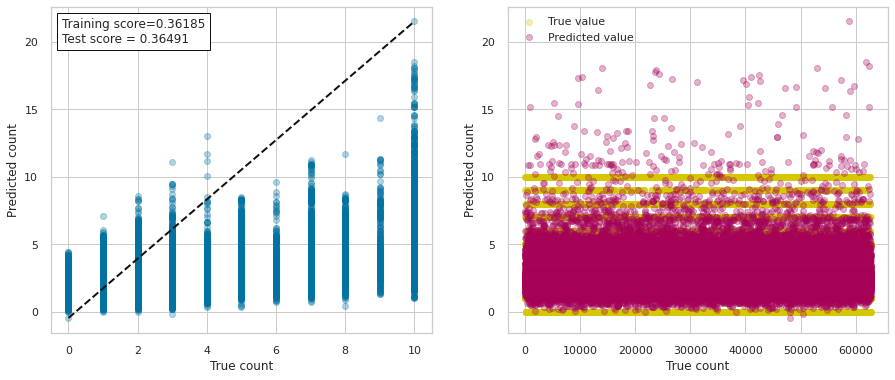

In [55]:
model_visualization(LinearRegression(), X, y, 'Linear_regression_all_features')

Lasso(alpha=0.0001)
Training score:  0.3632072507187941
Test score:  0.35948708455809353


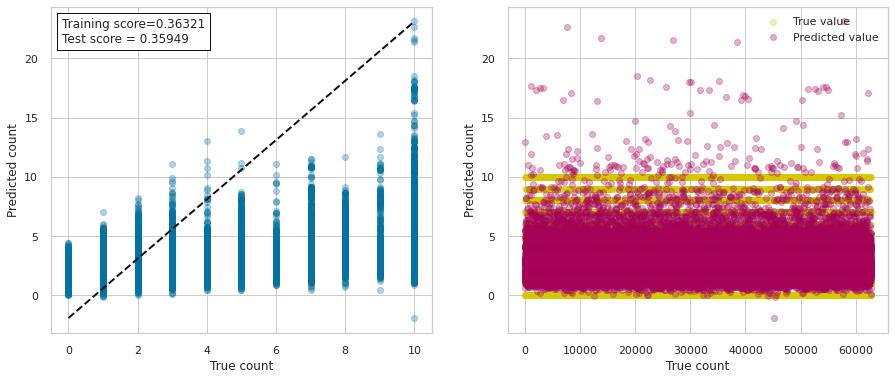

In [56]:
model_visualization(Lasso(alpha=0.0001), X, y, 'Linear_regression_all_features')

Ridge(alpha=0.0001)
Training score:  0.362999336054324
Test score:  0.36030766466123043


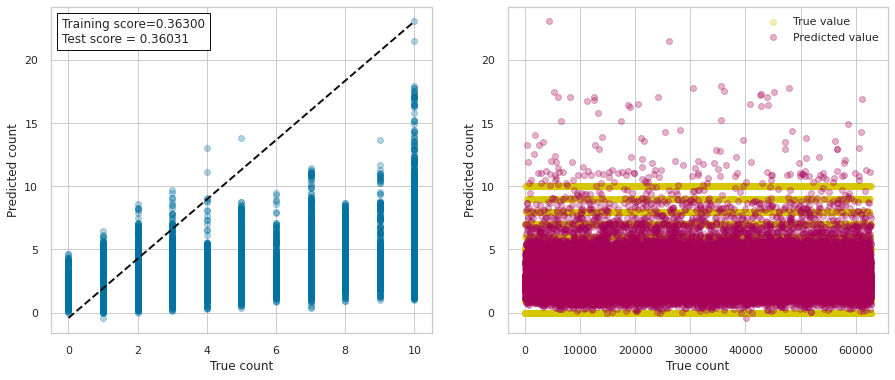

In [57]:
model_visualization(Ridge(alpha=0.0001), X, y, 'Linear_regression_all_features')

In conclusion, linear regression does not work very well for this problem, so we will move on to try othe more powerful models.

### Using pycaret library

[This powerful library](https://pycaret.org/) allows us to initialize, train, tune and ensemble models (and much more!). We will use it to quickly test various classification models on our data and see which work best for later fine-tuning.

In [ ]:
experiment = pyc.setup(data=enc_tra_data, target='Stay', train_size=0.8, silent=True, session_id=666)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:33:58
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data
